In [14]:
from pathlib import Path

import numpy as np
import pandas as pd

from numba import njit

from matplotlib import pyplot as plt

### Load data

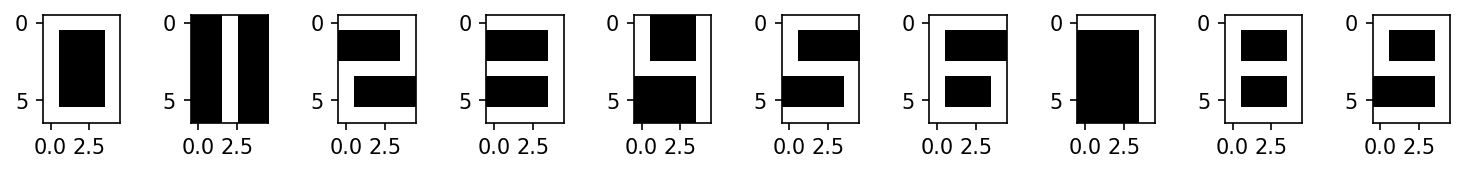

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

nums_mtrx = np.loadtxt(Path('data', 'numbers_7x5.txt'))

img_shape = (7, 5)
img_size = 35

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')

plt.tight_layout()
plt.show()

### Generate dataset

In [16]:
cells_columns = [f'c{n}' for n in range(img_size)]
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

df = pd.DataFrame(columns=cells_columns + ['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]

    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.5, img_size)

        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]

        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

### Split dataset to test and train

In [17]:
test_frac = 0.1

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

x_test = np.array(df.iloc[idx_test][features_columns])
y_test = np.array(df.iloc[idx_test][label_columns])

x_train = np.array(df.iloc[idx_train][features_columns])
y_train = np.array(df.iloc[idx_train][label_columns])

### Define model

In [18]:
@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)


@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, w: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        y = softmax(w @ x_batch[i] + b)

        dLdy = y - y_batch[i]
        
        dw += np.outer(dLdy, x_batch[i])
        db += dLdy

    return (dw, db)


class Perceptron:
    def __init__(self, nIn: int, nOut: int) -> None:
        self.nIn = nIn
        self.nOut = nOut

        self.w: np.ndarray = np.random.uniform(-1, 1, (nOut, nIn))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x: np.ndarray) -> np.ndarray:
        return softmax(self.w @ x + self.b)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr: float, batch_size: int, max_epoch: int) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n // batch_size):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dw, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.w, self.b)

                self.w -= lr * dw
                self.b -= lr * db

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        y_pred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(y_pred), axis=1)
        return np.mean(h)

### Create and train model

In [22]:
nIn = 35
nOut = 10

learning_rate = 1e-1
batch_size = 8
max_epoch = 100

model = Perceptron(nIn, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(5))

model.train(
    x_train,
    y_train,
    learning_rate,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test, y_test).round(5))

true_pos_count = 0

for x, y in zip(x_test, y_test):
    y_pred = model.predict(x)
    true_pos_count += 1 if np.argmax(y_pred) == np.argmax(y) else 0

accuracy = true_pos_count / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  0.29953
trained loss:  0.00134
test set accuracy: 100.0%


### Test model on big number of noised samples

In [23]:
n_samples = 10000
noise_size = 1.0

true_pos_count = 0

for i in range(n_samples):
    j = i % 10
    x = nums_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    y_pred = model.predict(x)
    true_pos_count += 1 if j == np.argmax(y_pred) else 0

accuracy = true_pos_count / x_test.shape[0]

print(f"accuracy: {round(accuracy * 100, 2)}% ({true_pos_count} of {n_samples})")

accuracy: 96.65% (9665 of 10000)


### Visualize model predictions

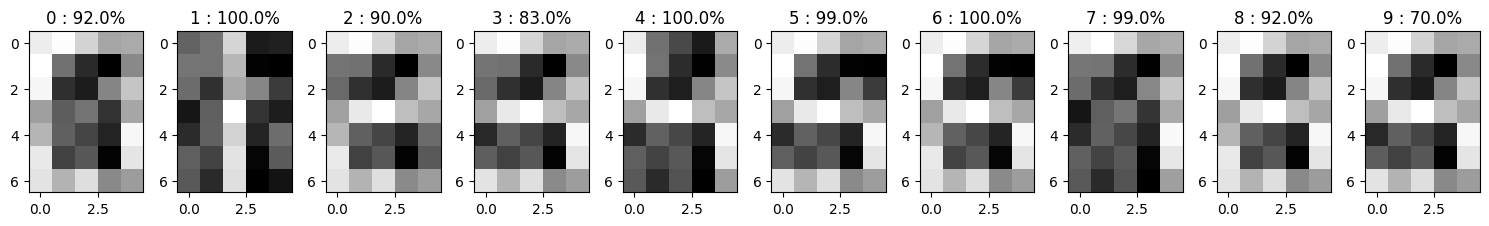

In [24]:
noise_size = 1.0
x_noised = nums_mtrx + np.random.uniform(0, noise_size, img_size)

y_pred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(y_pred[i])
    ax.set_title(f"{j} : {(y_pred[i][j] * 100).round()}%")

plt.tight_layout()
plt.show()